
## Compare Pytorch, ONNX, and CoreML Resnet50 Models

This notebook compares the predictions of six Resnet50 Models. It loads the original, intermediate and final models created by the conversions described in the previous Notebooks and compares the results for agreement. These models are named:

- **torchm** - Torch model from the torchvision distribution
- **t2o**    - An ONNX Model. The result of converting **torchm** to ONNX. The intermediate stage of conversion to CoreML
- **t2c**    - A CoreML Model. The result of convering the intermediate model **t2o** to CoreML.
    - ( The three models above are sometimes called the *"Torch Family"* )
    
    
- **onnxm**  - The ONNX Resnet50 model from the ONNX Model Zoo on Github
- **o2c**    - A CoreML Model. The result of converting **onnxm** to CoreML.
    - The two models above are sometimes called the *"ONNX Family"*
    
    
- **cml**    - A CoreML Model. To the five above I added the "native" CoreML Resnet50 model from the CoreML Model Zoo (Its an orphan)

This has become a long notebook.  Here is how it unfolds, in case you want to skip sections:

- Set test parameters, specify locations of test images
- Load and check the six models: ONNX, O2C, Torch, T2O, T2C, and CML (CoreML) (~ cell 14)
- Generate Predictions for each image using all models (~ cell 35)
- Check - show a small selection of results (~ cell 42 )
- Analyze how much agreement there was between models, create the Agreement Matrix (~ cell 45)
- Wrap up - Show some more results. (~ cell 58)

### Summary
If you don't want to wade thru all this (I don't blame you), here are the results:

>The *Torch Family* (*Torch -> t2o -> t2c*) seems to produce very consistent results. Their predictions agree about 95% of the time. That is good news, because ultimately I'd like to port a Torch Resnet50 Model of my own creation to CoreML.

>The *ONNX Family*  (*ONNX -> o2c*) predictions agree only about 75% of the time. A little surprising, that. 

>The native CoreML, ONNX and Torch models agree with each other between 75% and 55% percent of the time.

There is a full color-mapped **Agreement Matrix** in the *Agreement* sections, near the end.


#### Agreement Matrix

Here's the Agreement Matrix. Because it requires a lot of data and variables that do not exist until the entire notebook is run once, run the cell below ***only*** after doing that.

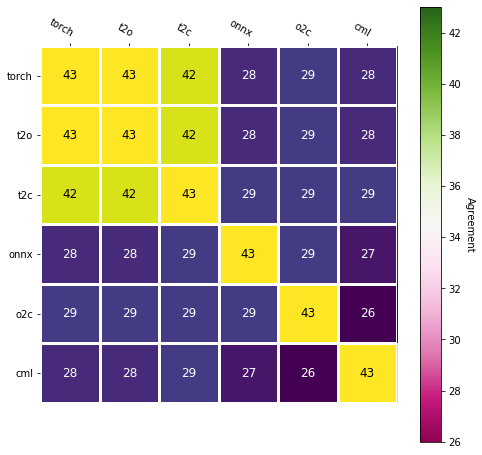

In [59]:
no_agree_counts = True
try:
    if len(agree_counts) > 0:
        no_agree_counts = True
        fig, ax = plt.subplots(figsize=(8,8))
        im, _ = heatmap(agree_counts, model_list, model_list, ax=ax,cmap="PiYG", cbarlabel="Agreement")
        annotate_heatmap(im, valfmt="{x:d}",textcolors=["white", "black"],size=12)
        im = ax.imshow(agree_counts)
        no_agree_counts = False
except Exception as e:
    no_agree_counts = True
    
if no_agree_counts: print("Execute cell above after running the entire notebook")


The cell below is common setup for this and other notebooks. You do have to run it, but you can ignore it otherwise.

In [6]:
# Notebook setup (initially %load(ed) from 'notebook_setup.py')

%reload_ext autoreload
%autoreload 0
%matplotlib inline

import numpy as np
from   pathlib import Path
# mcs utilities and helpers
from   ms_util import *

#Project Setup - Names & Commonly Used Values
project_name   = 'compare'   # Used as prefix for several derived names below
model_name     = 'resnet50'
model_arch     = 'Resnet50'   # Resnet50 , Resnet34, etc ...
img_size       = 300
batch_size     = 32

# %run -i {user_lib}/finish_setup.py [--show [Proj Paths Env] | None | All ] 
#
%run -i {user_lib}/finish_setup.py --show Proj

data_root       =  /Volumes/ArielD/storage
data_dir        =  /Volumes/ArielD/storage/data
proj_data_dir   =  /Volumes/ArielD/storage/data/compare
project_name    =  compare
proj_data_dir   =  /Volumes/ArielD/storage/data/compare
proj_dir        =  /Users/mcsieber/storage/notebooks/compare
model_name      =  resnet50
model_arch      =  Resnet50
models_dir      =  /Volumes/ArielD/storage/data/compare/models
img_size        =  300
batch_size      =  32



## Additional Setup

In [7]:
from PIL import Image
from PIL import ImageOps
from pred_help import *
from coreml_help import *
mlmodels_dir = data_dir/'mlmodels'  # Where to find downloaded CoreML models
resize_method = Image.NEAREST       # How to resample images when they are resized

**Test Data** - Specify locations for test and validation images

In [8]:
test_root     = data_root/'data'
test_data_dir = data_dir/'test'
imagenet_dir  = data_dir/'imagenet'
imagenet_path = imagenet_dir/'img_net_labels.txt'

In [9]:
dogcat_dir    = test_root/'dogscats/large/valid-large'
flowers_dir   = test_root/'flowers/data'
fruit_dir     = test_root/'food_poc/data'
food_dir      = Path('/Volumes/ArielD/storage/data/food/images')
pp((dogcat_dir, flowers_dir, food_dir,fruit_dir))

dogcat_dir     =  PosixPath('/Volumes/ArielD/storage/data/dogscats/large/valid-large')
flowers_dir    =  PosixPath('/Volumes/ArielD/storage/data/flowers/data')
food_dir       =  PosixPath('/Volumes/ArielD/storage/data/food/images')
fruit_dir      =  PosixPath('/Volumes/ArielD/storage/data/food_poc/data')


**Test Data** - Get random images from various test image sets

In [10]:
img_per_dir = 10     # Get this many images per directory
max_sample  = 400    # Max sample range (set limit in case it is a huge directory)
#
t0 = get_rand_images(food_dir,   n_images=int(img_per_dir*3), search_limit=max_sample)
t1 = get_rand_images(dogcat_dir, n_images=img_per_dir, search_limit=max_sample)
t2 = get_rand_images(flowers_dir,n_images=img_per_dir, search_limit=max_sample)
t3 = get_rand_images(fruit_dir,  n_images=img_per_dir, search_limit=max_sample)
test_imgs = t0+t1+t2+t3
#
f"{len(test_imgs)} test images"

'43 test images'

Get validation images to sanity check the models as we load them

In [11]:
vimg_path  = Path('/Volumes/ArielD/storage/data/food_poc/data/apples/apple_029.jpg')
vimg300    = ImageOps.fit(Image.open(vimg_path),(300,300), method=resize_method, centering=(0.5,0.4))
vimg224    = ImageOps.fit(Image.open(vimg_path),(224,224), method=resize_method, centering=(0.5,0.4))

**Class Labels** - Load the class labels from a disk file .These are the [1000 class labels](https://s3.amazonaws.com/onnx-model-zoo/synset.txt) for ImageNet. 

In [12]:
with open(imagenet_path, 'r') as list_ : 
    inet_labels = [line.rstrip() for line in list_ ]

**Normalization for ImageNet** - Calculate Scale and Bias for ONNX and CoreML models

As recommended, input images for the ONNX model are normalized
using the mean and standard deviation for **ImageNet**.
(For details, see Help or Notes for `imagenet_normalize`):

For the CoreML models, we use the values above to calculate an *image scale*
and (Red, Green, Blue) *channel biases* that acheive the same effect.

In [13]:
# Values for ONNX ImageNet normalization
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

# For CoreML from ONNX, calculate scale and bias to reproduce normalization
ppargs = dict(
    image_scale= 1/(255.0*std.mean()),
    red_bias   = - mean[0]/std[0],
    green_bias = - mean[1]/std[1],
    blue_bias  = - mean[2]/std[2]
)
ppargs

{'image_scale': 0.01735207357279195,
 'red_bias': -2.1179039301310043,
 'green_bias': -2.0357142857142856,
 'blue_bias': -1.8044444444444445}

### ONNX
Load [ONNX Resnet50(v2)](https://s3.amazonaws.com/onnx-model-zoo/resnet/resnet50v2/resnet50v2.tar.gz) model and check that it works. This model was downloaded from the [ONNX Model Zoo](https://github.com/onnx/models)

In [14]:
import onnx
import onnxruntime as ort

In [15]:
onnxm_name   = 'resnet50.onnx'
onnxm_path   = data_dir/'onnx/resnet50v2'/onnxm_name ; onnxm_path

PosixPath('/Volumes/ArielD/storage/data/onnx/resnet50v2/resnet50.onnx')

In [16]:
onnxm = onnx.load(onnxm_path)
onnx.checker.check_model(onnxm)

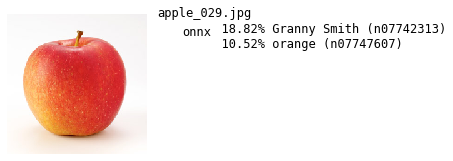

In [17]:
onnx_rt  = ort.InferenceSession(onnxm_path.as_posix())
pred     = pred_for_onnx(onnx_rt,vimg300,labels=inet_labels)
show_pred(vimg_path,pred,model_id='onnx');

### O2C 
O2C - Load and check the CoreML model converted from the ONNX above

In [18]:
import coremltools.models as cm

In [19]:
o2c_name = 'o2c.mlmodel'
o2c_path = models_dir/o2c_name ; o2c_path

PosixPath('/Volumes/ArielD/storage/data/compare/models/o2c.mlmodel')

In [20]:
o2c  = cm.MLModel(o2c_path.as_posix())

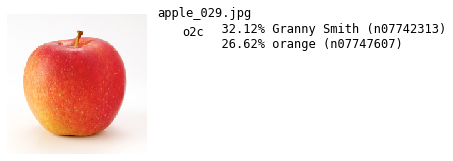

In [21]:
pred = pred_for_o2c(o2c,vimg224,labels=inet_labels)
show_pred(vimg_path, pred, model_id='o2c');

### Torch
Load and check a standard Torch Resnet50

In [22]:
import torch
import torchvision

In [23]:
torchm_name = 'torch.pth'
torchm_path = models_dir/torchm_name

In [24]:
torchm = torchvision.models.resnet50(pretrained=True)
torchm.eval()  # Must set to evaluation mode to generate predictions
labels = inet_labels

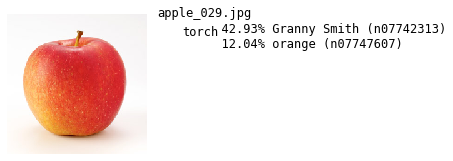

In [25]:
pred = pred_for_torch(torchm,vimg300,labels=inet_labels)
show_pred(vimg_path,pred, model_id='torch');

### T2O
T2O - Load and check ONNX model converted from Torch. This model is the intermediate stage of the *Torch->ONNX-CoreML* conversion process.

In [26]:
# T2O - Torch to Onnx
t2o_name = 't2o.onnx'
t2o_path = models_dir/t2o_name

In [27]:
t2o = onnx.load(t2o_path)
onnx.checker.check_model(t2o)

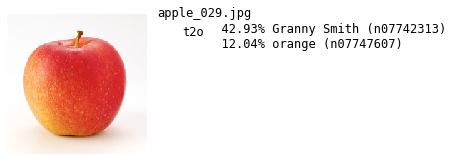

In [28]:
t2o_rt  = ort.InferenceSession(t2o_path.as_posix())
pred = pred_for_onnx(t2o_rt,vimg300,labels=inet_labels)
show_pred(vimg_path,pred,model_id='t2o');

### T2C
T2C - Load and check the *repaired* CoreML model converted from Torch via ONNX.

In [29]:
t2c_name = 't2c.mlmodel'
t2c_path = models_dir/t2c_name

In [30]:
t2c  = cm.MLModel(t2c_path.as_posix())

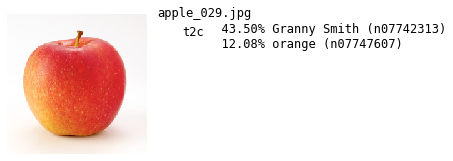

In [31]:
pred = pred_for_o2c(t2c,vimg300,labels=inet_labels)
show_pred(vimg_path,pred,model_id='t2c');

### CoreML
CML - Load and check a standard CoreML Resnet50 model

In [32]:
coreml_name = 'Resnet50.mlmodel'
coreml_path = mlmodels_dir/'Resnet50'/coreml_name

In [33]:
cml = cm.MLModel(coreml_path.as_posix())

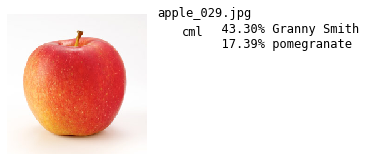

In [34]:
pred = pred_for_coreml(cml,vimg224)
show_pred(vimg_path,pred, model_id='cml');

## Predictions

For each of the test images, generate a prediction from each of the six models and save the results

In [35]:
import matplotlib.pyplot as plt

### Setup

The prediction code uses three lists to gather results:
- **results** - Records the prediction results for each model for each image.
- **top_prob** - 3d ndarray containing `top_num` probabilities for each prediction. Order is: *model #, image #, probs*
- **top_classes** - 3d ndarray containing `top_num` classes (indexes for each prediction). Order is: *model #, image #, probs*

The code expects a *"result template"* that specifies the models and model short names we are going to use.

Specify the models to be included in the results, and set the number of predictions to return, and the number of predictions to show. Use those values to generate *model short names* <--> *number mappings*, and allocate the arrays which capture result information

In [36]:
num_top     = 3  # Number of top prediction items (classes, probs, labels) to return (3 is default)
num_to_show = 2  # Number of probabilities to show for each prediction.
#
result_template = { 'name' : '', 'path' : None,
        'torch': pred_for_torch,
        't2o'  : pred_for_onnx,
        't2c'  : pred_for_o2c,
        'onnx' : pred_for_onnx,
        'o2c'  : pred_for_o2c,
        'cml'  : pred_for_coreml,
    # additional models would go here
}

Generate parameters for code cells below

In [37]:
num_imgs   = len(test_imgs)  # Number of images
rep_every  = int(num_imgs/4) # Interval for reporting progress
model_list = [k for k in result_template if k not in ['name','path']]
num_models = len(model_list)
i2m        = model_list # synonym; model index --> model name
m2i        = {m:i for i,m in enumerate(model_list)}  # model name --> model index
model_list

['torch', 't2o', 't2c', 'onnx', 'o2c', 'cml']

Allocate the arrays that will contain the results

In [38]:
top_prob    = np.empty((num_models, num_imgs, num_top), dtype=float)
top_classes = np.empty((num_models, num_imgs, num_top), dtype=int)
results     = [result_template] * num_imgs
#
tp = top_prob # Synonym
tc = top_classes #Synonym

### Predictions
Get predictions on each test image from all models and save the results

(NOTE: The 'res' dictionary keys below must correspond to the "result_template" above) 

(... yes I know that's ugly, I'll fix it next time ...)

This function will probably move to the `pred_help` module, but leaving it here for now helps to show what is going on.

In [39]:
def pred_results(path)->dict:
    """ Get all predictions for one image and return an result item dict for the results list"""
    name   = Path(path).name
    img    = Image.open(path)
    
    # Fix RGBA images (or others) on the fly, if possible ...
    if img.mode != 'RGB':  
        print(f'Attempting to convert {name} from {img.mode} to RGB')
        img = img.convert('RGB')
        
    # Some of the models are picky about the image size ...
    img300 = ImageOps.fit(img,(300,300), method=resize_method, centering=(0.5,0.4))
    img224 = ImageOps.fit(img,(224,224), method=resize_method, centering=(0.5,0.4))
    
    # Assign the result to a local for now, to make debugging easier
    res = {'name' : name, 'path' : path.as_posix(),
        'torch': pred_for_torch(torchm,img300,labels=inet_labels),
        't2o'  : pred_for_onnx(t2o_rt,img300, labels=inet_labels),
        't2c'  : pred_for_o2c(t2c,img300,labels=inet_labels),
        'onnx' : pred_for_onnx(onnx_rt,img300, labels=inet_labels),
        'o2c'  : pred_for_o2c(o2c,img224,labels=inet_labels),
        'cml'  : pred_for_coreml(cml,img224),
     }
    return res

Get predictions on each test image from all models and save the results

(...Should revise to do in *batch mode* for anything more that a few images ...)

In [40]:
for i, path in enumerate(test_imgs):
    results[i] = pred_results(path)
    if (i%rep_every)== 0 : print(f"{i} of {num_imgs} images processed, most recent is {path.name} ")

    # Capture copies of class indexes and probabilities and 
    # save in numpy arrays by model for later calculation
    for im, model in enumerate(model_list): 
        model_result = results[i][model]
        top_classes[im][i] = np.array(model_result.topI)
        top_prob[im][i]    = np.array(model_result.topP)
        
print(f"Total of {i+1} images processed")

0 of 43 images processed, most recent is roots_086.jpg 
10 of 43 images processed, most recent is steak_186.jpg 
20 of 43 images processed, most recent is dog.3140.jpg 
30 of 43 images processed, most recent is 2607130050_9c34310004.jpg 
40 of 43 images processed, most recent is apple_203.jpg 
Total of 43 images processed


`show_result` - a helpful routine for the next section.  Another candidate to move to `pred_help`, evenutally.

In [41]:
def show_result(result,n2show=num_to_show):
    """Show the image and predictions for one image (= one item in the results list)"""
    img_path   = result["path"]
    # Don't assume that the model list is global, or even if it is, that it is correct for this item ...
    model_list = [k for k in result if k not in ['name','path']]
    m0 = model_list.pop(0)
    axs, x, y  = show_pred(img_path, result[m0], model_id=m0,n_2show=n2show,fig_size=(3.0,4.0), immediate=False )
    for m in model_list:
        x, y   = add_pred(axs,x,y,result[m],model_id=m, n_2show=n2show )
    plt.show()

### Check Results 
To see what we have, lets look at a few results before we start comparison and agreement calculations

In [42]:
import random
import matplotlib.pyplot as plt

In [43]:
results_to_show = 4
probs_to_show = 2


Showing results [5, 12, 19, 35] 
  and top 2 probablities from each model


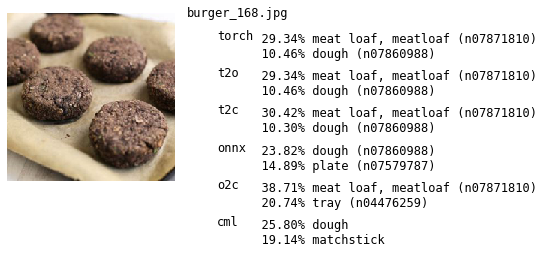

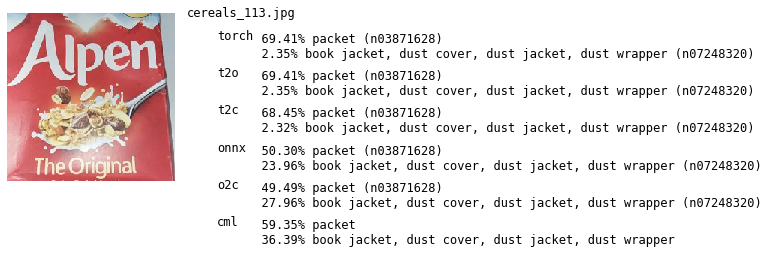

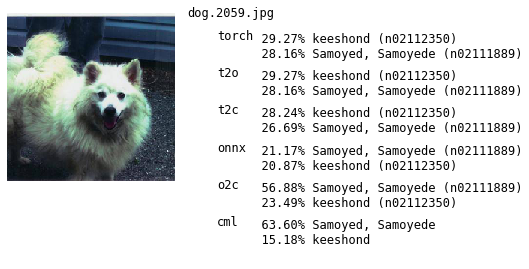

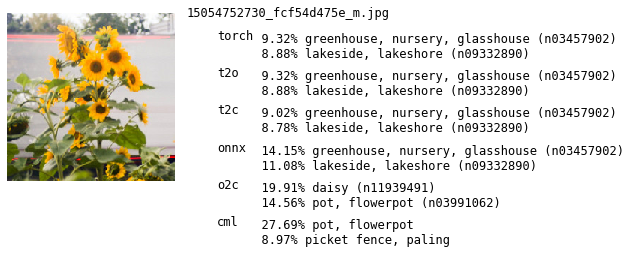

In [44]:
display_list = random.sample(range(len(results)), results_to_show)
display_list.sort()
print(f"\nShowing results {display_list} \n  and top {probs_to_show} probablities from each model")
for i in display_list: show_result(results[i],n2show=probs_to_show)

## Agreement?
How often does **T2C** agree with the other models? (A quick recap: T2C is the end result the *Torch->ONNX->CoreML* conversion path)

To get that answer, we create an "Agreement Matrix" (similar to a Confusion Matrix)

In [45]:
from copy import copy

In [46]:
mlen  = len(model_list)
nimgs = num_imgs

Allocate the 2 and 3 dim arrays we will need

In [47]:
agree     = np.empty((mlen,mlen,nimgs),dtype=bool)
agree_counts = np.empty((mlen,mlen),dtype=int)
agree_diff = np.empty((mlen,mlen,nimgs),dtype=float)

Populate the agreement tensors (CML will need to be revised ... see below)

In [48]:
for im,m in enumerate(model_list):
    for ik,k in enumerate(model_list):
        agree[im,ik]      = tc[im,:,0] == tc[ik,:,0]
        agree_counts[im,ik]= agree[im,ik].sum()
        agree_diff[im,ik] = abs(tp[im,:,0] - tp[ik,:,0])

CML is a special case.
The native CoreML model returns the *class labels* as part of its output. The text of these labels corresponds to the text of the *Imagenet* labels, but their *class number* (ordering) does not, so we can't use the class number (the index for the label in the `inet_labels` list) to compare CML class predictions to other models. We have to match the text of the CML labels directly against the *Imagenet* labels.

In [50]:
# A results comparison function just for cml ...
def cml_compare(res:dict)->ndarray:
    """ 
    For this result item (i.e. image), compare the top CML label to the top label for the other models
    Return boolean array indicating which models agree with CML and which do not
    """
    # Allocate an empty array, get the CML label, clean it up
    rcml_agree = np.empty(mlen,dtype=bool)
    cml_label  = res['cml'].topL[0]
    cml_label.strip(' ,-:;')
    # Compare the CML label to each of the top labels for the other models
    for im,m in enumerate(model_list):
        mlabel = res[m].topL[0]
        rcml_agree[im] = mlabel.find(cml_label) >= 0
     #   
    return rcml_agree

Add CML results to the `agree` and `agree_counts` arrays

In [51]:
CML = m2i['cml']

for ir,r in enumerate(results):
    agree[CML,:,ir] = cml_compare(r)
    
for im,m in enumerate(model_list): 
    asum = agree[CML,im,:].sum()
    agree_counts[CML,im] = asum
    agree_counts[im,CML] = asum

**Agreement** - Now we can answer the question: How often does **T2C** agree with predictions from the other models?

In [52]:
T2C  = m2i['t2c']
for im,m in enumerate(model_list):
    agreed = agree_counts[T2C,im]
    print(f"T2C and {m:5} agree on {agreed:3} images out of {nimgs:3} = {agreed/nimgs:2.2%}")

T2C and torch agree on  42 images out of  43 = 97.67%
T2C and t2o   agree on  42 images out of  43 = 97.67%
T2C and t2c   agree on  43 images out of  43 = 100.00%
T2C and onnx  agree on  29 images out of  43 = 67.44%
T2C and o2c   agree on  29 images out of  43 = 67.44%
T2C and cml   agree on  29 images out of  43 = 67.44%


### Agreement Matrix
The full agreement matrix is displayed below.

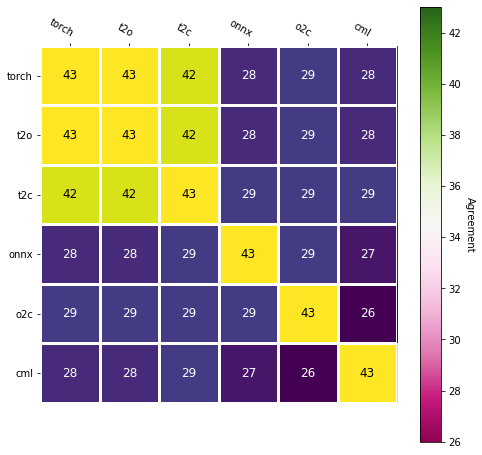

In [53]:
fig, ax = plt.subplots(figsize=(8,8))
im, _ = heatmap(agree_counts, model_list, model_list, ax=ax,cmap="PiYG", cbarlabel="Agreement")
annotate_heatmap(im, valfmt="{x:d}",textcolors=["white", "black"],size=12)
im = ax.imshow(agree_counts)

The *Torch Family* (*Torch -> t2o -> t2c*) seems to produce very consistent results. Their predictions agree about 95% of the time. That is good news, because ultimately I'd like to port a Torch Resnet50 Model of my own creation to CoreML.

The *ONNX Family* agrees with itself only about 75% of the time. A little surprising, that. 

The native CoreML, ONNX and Torch models agree with each other between 75% and 55% percent of the time.

## Agreement Quality
How *well* does **T2C** agree with other models? To answer this question, we can use the `agree_diff` array from above. This array records the *differences* between prediction probabilities.

For example, to see the differences between the predicted (top) probabilities for each image for T2C and TORCH:

In [54]:
TORCH  = m2i['torch']
ttdiff = agree_diff[T2C,TORCH];
ttdiff

array([0.0061, 0.0064, 0.0048, 0.0124, 0.0124, 0.0108, 0.0003, 0.001 , 0.0029, 0.0028, 0.036 , 0.02  , 0.0096, 0.0121, 0.0008,
       0.0194, 0.0014, 0.0146, 0.0068, 0.0103, 0.0153, 0.0048, 0.002 , 0.0002, 0.0003, 0.0033, 0.0158, 0.005 , 0.0012, 0.0021,
       0.0048, 0.0078, 0.0064, 0.021 , 0.0116, 0.003 , 0.0012, 0.0036, 0.0053, 0.0111, 0.0148, 0.0036, 0.017 ])

All of these are very close - a lot of agreement.  More useful probably is to get basic stats for these differences: max, min, mean, and std

In [55]:
pp((ttdiff.max(), ttdiff.min(), ttdiff.mean(), ttdiff.std()))

ttdiff.max(    =  0.03597470752531273
ttdiff.min()   =  0.0001654552910846374
ttdiff.mean()  =  0.008191974886893874
 ttdiff.std(   =  0.007287786976668954


### Agreement - Best and Worst
For max and min, we can show not only the number, but the image. For T2C and TORCH, here is image with the best agreement (min difference), followed by the image with the worst agreement (max difference)

ttdiff.min(    =  0.0001654552910846374


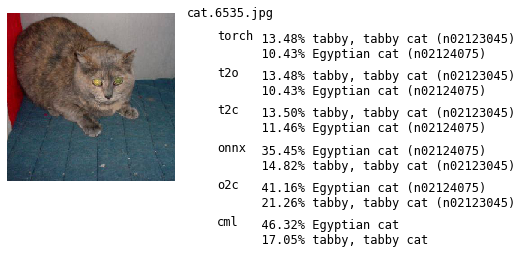

(None, None)

In [56]:
pp(ttdiff.min()), show_result(results[ttdiff.argmin()])

ttdiff.max(    =  0.03597470752531273


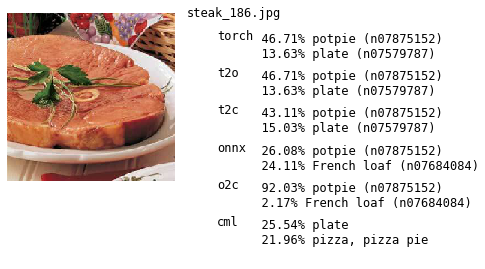

(None, None)

In [57]:
pp(ttdiff.max()), show_result(results[ttdiff.argmax()])

**Note for Future Work:** Selecting comparisons with a minimum difference is not quite enough. It would be useful to know if the predictions are *correct*. And we would like the prediction to have adequate *certainty*.

For example, if TORCH and T2C agree exactly, but the probability on which they agree is 2.01%, the prediction on which they are agreeing is likely to be wrong. So to get a better picture of Agreement Quality, we have to qualify the minimum differences by accuracy and certainty (probability).

*But I'll tackle that in the next round of comparison.  This notebook has gotten big enough!*

## Wrap Up - A Few More Result Pictures
Finally, to wrap up, here is another selection of images and their predictions


Showing results [0, 10, 11, 17, 20, 21, 30, 39] 
  and top 2 probablities for each model


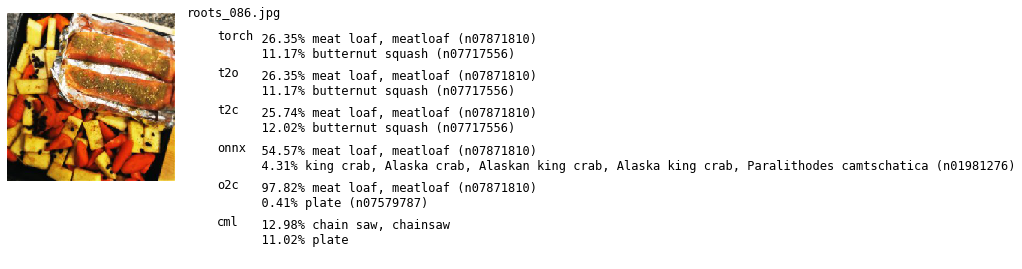

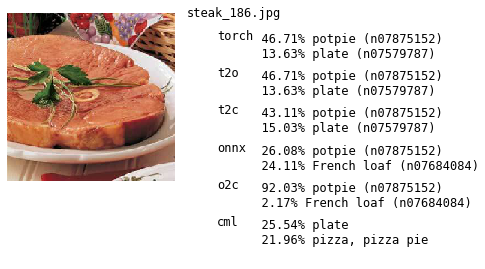

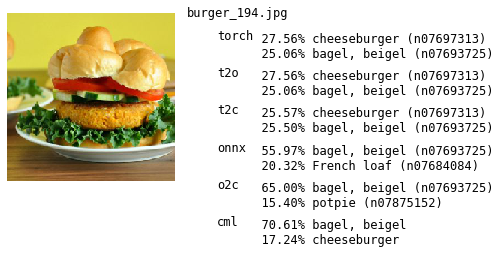

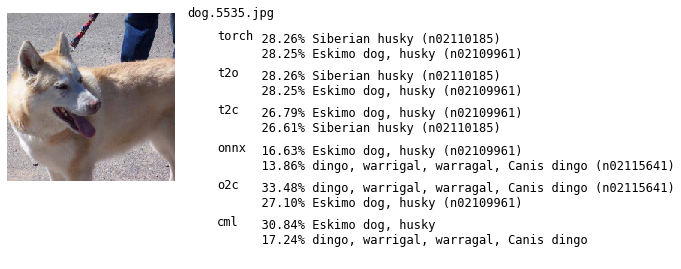

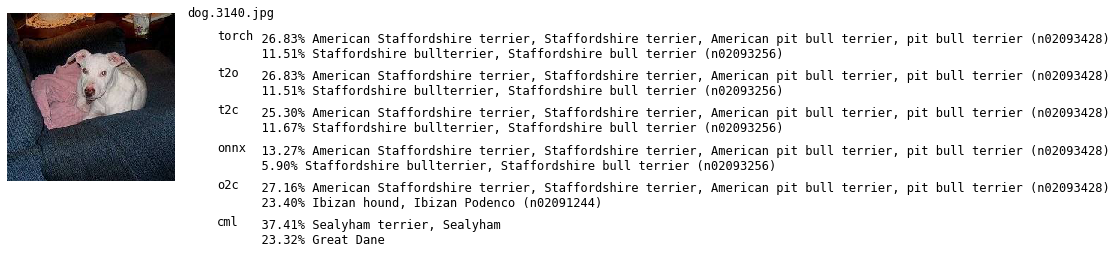

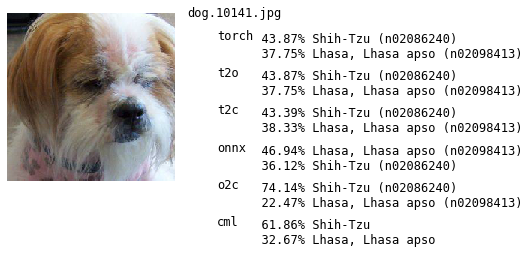

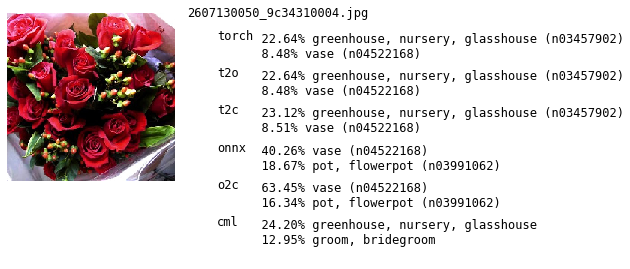

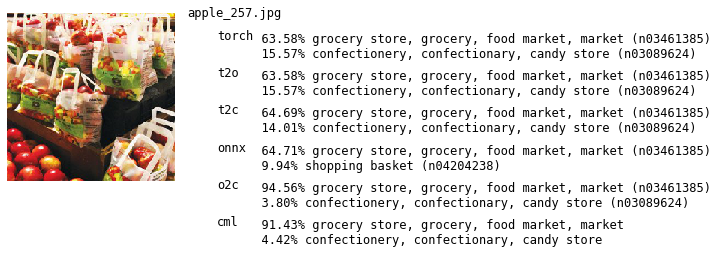

In [58]:
results_to_show = 8
probs_to_show = 2
#
display_list = random.sample(range(len(results)), results_to_show)
display_list.sort()
print(f"\nShowing results {display_list} \n  and top {probs_to_show} probablities for each model")
for i in display_list: show_result(results[i],n2show=probs_to_show)